# Nazcaan classification

This tutorial shows how to classify Naazcan script. It creates an image classifier using a `keras.Sequential` model, and loads data using `preprocessing.image_dataset_from_directory`. You will gain practical experience with the following concepts:

* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and Dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

## Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

ModuleNotFoundError: No module named 'matplotlib'

## Explore the dataset

In [3]:
import pathlib
data_dir = pathlib.Path("dataset/letters")
data_dir

WindowsPath('dataset/letters')

Print total images

In [4]:
image_count = len(list(data_dir.glob('*/*.PNG')))
print(image_count)

2


Here are some Es:

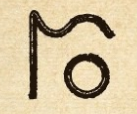

In [6]:
zeros = list(data_dir.glob('E/*'))
PIL.Image.open(str(zeros[0]))

And some Fs:

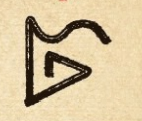

In [7]:
nines = list(data_dir.glob('F/*'))
PIL.Image.open(str(nines[0]))

# Load using keras.preprocessing

Let's load these images off disk using the helpful [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [load images](https://www.tensorflow.org/tutorials/load_data/images) tutorial.

## Create a dataset

Define some parameters for the loader:

In [8]:
img_height = 130
img_width = 100

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height, img_width))

Found 2 files belonging to 2 classes.


In [10]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [11]:
class_names = train_ds.class_names
class_names

['E', 'F']

In [22]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height, img_width))

Found 2 files belonging to 2 classes.


## Overfitting

In [18]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomZoom(0.1)
  ]
)

typeof

In [12]:
type(data_augmentation)

tensorflow.python.keras.engine.sequential.Sequential

Visualize traind data with data_augmentation

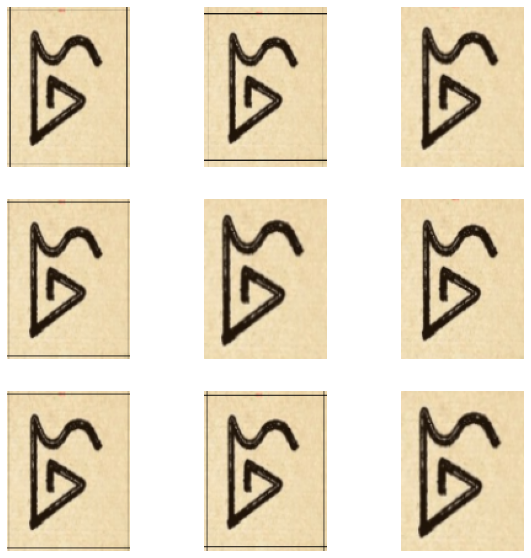

In [21]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Visualize validation images with data_augmentation

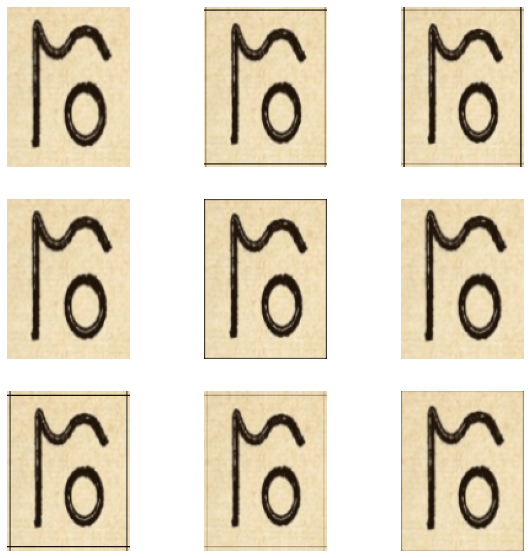

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in val_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Visualize the data

Here are the first 5 images from the training dataset.

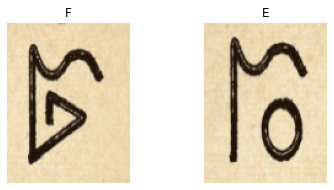

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(2):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a `relu` activation function. This model has not been tuned for high accuracy, the goal of this tutorial is to show a standard approach. 

In [36]:
num_classes = 2

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the model

For this tutorial, choose the `optimizers.Adam` optimizer and `losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [46]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary

View all the layers of the network using the model's `summary` method:

In [47]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 130, 100, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 130, 100, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 130, 100, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 65, 50, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 65, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 25, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 25, 64)       

## Train the model

In [39]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
1/1 [==============================] - 0s 234ms/step - loss: 0.7060 - accuracy: 0.5000 - val_loss: 0.8483 - val_accuracy: 0.5000
Epoch 2/30
1/1 [==============================] - 0s 81ms/step - loss: 0.8089 - accuracy: 0.5000 - val_loss: 0.6842 - val_accuracy: 0.5000
Epoch 3/30
1/1 [==============================] - 0s 77ms/step - loss: 0.6348 - accuracy: 0.5000 - val_loss: 0.6402 - val_accuracy: 0.5000
Epoch 4/30
1/1 [==============================] - 0s 78ms/step - loss: 0.6373 - accuracy: 0.5000 - val_loss: 0.5247 - val_accuracy: 1.0000
Epoch 5/30
1/1 [==============================] - 0s 87ms/step - loss: 0.5395 - accuracy: 1.0000 - val_loss: 0.4596 - val_accuracy: 1.0000
Epoch 6/30
1/1 [==============================] - 0s 79ms/step - loss: 0.5228 - accuracy: 1.0000 - val_loss: 0.4258 - val_accuracy: 1.0000
Epoch 7/30
1/1 [==============================] - 0s 75ms/step - loss: 0.5313 - accuracy: 0.5000 - val_loss: 0.3344 - val_accuracy: 1.0000
Epoch 8/30
1/1 [==========

## Visualize training results

Create plots of loss and accuracy on the training and validation sets.

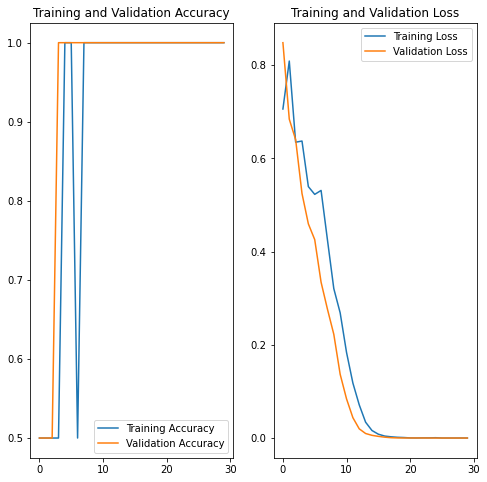

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Finally, let's use our model to classify an image that wasn't included in the training or validation sets. It must validate to letter E

Note: Data augmentation and Dropout layers are inactive at inference time.

In [45]:
image_url = "https://raw.githubusercontent.com/alefcarlos/nazcaan-deep-learning/main/to-validate.PNG"
predicte_image_path = tf.keras.utils.get_file('predictImage.png', origin=image_url)

print(predicte_image_path)

img = keras.preprocessing.image.load_img(
    predicte_image_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

C:\Users\alefc\.keras\datasets\predictImage.png
This image most likely belongs to E with a 91.98 percent confidence.


End